In [1]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Now import other libraries or define your model


In [2]:
import ctypes
try:
    ctypes.WinDLL('zlibwapi.dll')  # Test loading the DLL
    print("Success: zlibwapi.dll is accessible!")
except Exception as e:
    print(f"Error: {e}")

Success: zlibwapi.dll is accessible!


In [3]:
import os
import numpy as np
from PIL import Image
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [4]:
from keras import backend as K

# Clear previous sessions
K.clear_session()

In [5]:
class AgeDataGenerator(Sequence):
    def __init__(self, image_info_list, batch_size=16, img_size=(128, 128), shuffle=True):
        self.image_info = image_info_list
        self.batch_size = batch_size
        self.img_size = img_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_info) / self.batch_size))

    def __getitem__(self, index):
        batch_info = self.image_info[index * self.batch_size : (index + 1) * self.batch_size]
        X, y = self.__data_generation(batch_info)
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.image_info)

    def __data_generation(self, batch_info):
        X, y = [], []
        for path, age in batch_info:
            try:
                img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, self.img_size)
                img = np.expand_dims(img, axis=-1)
                img = np.repeat(img, 3, axis=-1)
                img = img.astype(np.float32) / 255.0
                X.append(img)
                y.append(age)
            except:
                continue
        return np.array(X), np.array(y)

In [6]:
metadata_path = "Dataset/meta_train.csv"
metadata_df = pd.read_csv(metadata_path)
metadata_df.set_index('image_id', inplace=True)

image_info_list = []
base_path = "Dataset/preprocessed_images"
labels = os.listdir(base_path)

for label in labels:
    folder = os.path.join(base_path, label)
    image_files = os.listdir(folder)
    base_names = sorted(set(f.split('_')[0] for f in image_files if f.endswith("_nipy_spectral.jpg")))

    for base in base_names:
        spectral_path = os.path.join(folder, f"{base}_nipy_spectral.jpg")
        if not os.path.exists(spectral_path):
            continue

        image_id = base + ".jpg"
        if image_id in metadata_df.index:
            age = float(metadata_df.loc[image_id, "age"])
            image_info_list.append((spectral_path, age))

In [7]:
train_list, val_list = train_test_split(image_info_list, test_size=0.2, random_state=42)
train_gen = AgeDataGenerator(train_list, batch_size=16, img_size=(128, 128))
val_gen = AgeDataGenerator(val_list, batch_size=16, img_size=(128, 128))

In [8]:
input_tensor = Input(shape=(128, 128, 3))
base_model = EfficientNetB0(include_top=False, weights=None, input_tensor=input_tensor)

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.05))(x)
x = Dropout(0.7)(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
output = Dense(1, activation='linear')(x)

model = Model(inputs=base_model.input, outputs=output)

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.9
)
optimizer = Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer, loss='mae', metrics=['mae'])

In [9]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=60,
)

Epoch 1/60
521/521 [==============================] - 110s 191ms/step - loss: 22.4729 - mae: 17.5282 - val_loss: 12.5091 - val_mae: 8.4642
Epoch 2/60
521/521 [==============================] - 95s 182ms/step - loss: 13.0917 - mae: 9.6405 - val_loss: 13.9136 - val_mae: 10.8398
Epoch 3/60
521/521 [==============================] - 95s 183ms/step - loss: 11.5275 - mae: 8.8691 - val_loss: 9.9568 - val_mae: 7.7700
Epoch 4/60
521/521 [==============================] - 95s 183ms/step - loss: 10.4370 - mae: 8.4683 - val_loss: 10.7711 - val_mae: 9.0985
Epoch 5/60
521/521 [==============================] - 95s 183ms/step - loss: 10.0081 - mae: 8.3396 - val_loss: 9.3186 - val_mae: 7.8145
Epoch 6/60
521/521 [==============================] - 95s 183ms/step - loss: 9.5706 - mae: 8.1400 - val_loss: 8.9174 - val_mae: 7.6500
Epoch 7/60
521/521 [==============================] - 95s 183ms/step - loss: 9.4112 - mae: 8.0964 - val_loss: 9.1292 - val_mae: 7.6666
Epoch 8/60
521/521 [========================

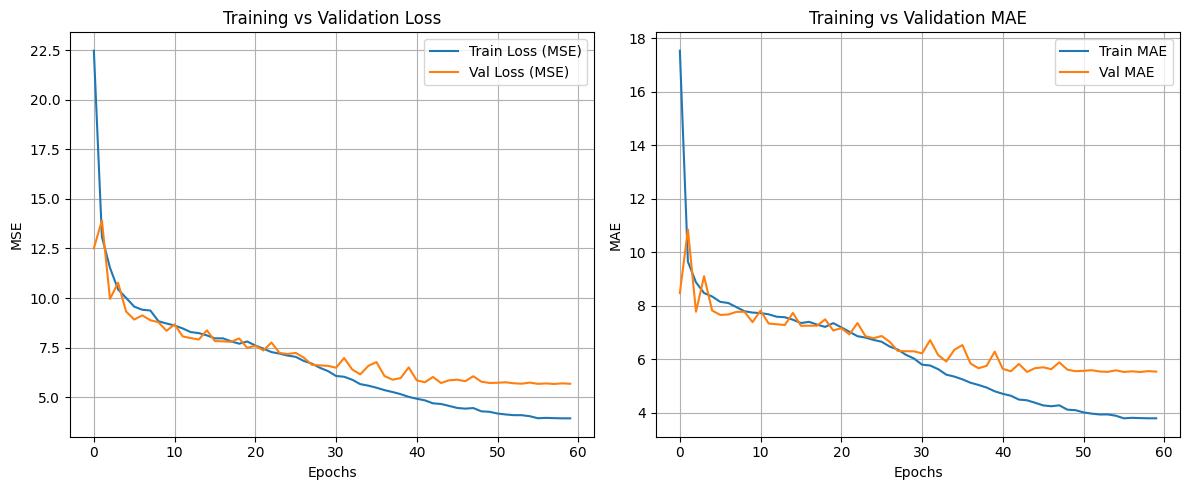

In [10]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss (MSE)')
plt.plot(history.history['val_loss'], label='Val Loss (MSE)')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('Training vs Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [11]:
TEST_DIR = "Dataset/preprocessed_test_images"
OUTPUT_CSV = "task3_spectral_predictions.csv"
MODEL_INPUT_SIZE = (128, 128)

all_files = os.listdir(TEST_DIR)
image_ids = sorted(set(f.split("_")[0] for f in all_files if f.endswith("_nipy_spectral.jpg")))

results = []

for img_id in image_ids:
    try:
        spectral_path = os.path.join(TEST_DIR, f"{img_id}_nipy_spectral.jpg")

        if not os.path.exists(spectral_path):
            print(f"Missing spectral image for {img_id}, skipping...")
            continue

        s = cv2.imread(spectral_path, cv2.IMREAD_GRAYSCALE)
        s = cv2.resize(s, MODEL_INPUT_SIZE)

        stacked = np.repeat(s[:, :, np.newaxis], 3, axis=-1).astype(np.float32) / 255.0

        img_input = np.expand_dims(stacked, axis=0)
        pred = model.predict(img_input, verbose=0)[0][0]

        results.append({
            "image_id": img_id + ".jpg",
            "age": round(pred, 2)
        })

    except Exception as e:
        print(f"Error processing {img_id}: {e}")

df = pd.DataFrame(results)
df.to_csv(OUTPUT_CSV, index=False)
print(f"Saved predictions to {OUTPUT_CSV}")


Saved predictions to task3_spectral_predictions.csv
